### Import libraries

In [7]:
import pandas as pd
import numpy as np
import clickhouse_connect

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# Initial Docker Setup

### Create user with sha256 pass and rm default user (./users/default-user.xml)
> past file `konsin1988-user.xml` in users dir

>Enable SQL user mode:

```<access_management>1</access_management>```<br>
```<named_collection_control>1</named_collection_control>```<br>
```<show_named_collections>1</show_named_collections>```<br>
```<show_named_collections_secrets>1</show_named_collections_secrets>```<br>

 

### Get clickhouse client from docker

In [3]:
client = clickhouse_connect.get_client(host = 'localhost', port = '8123', user = 'konsin1988', password = 'konsin1988konsin1988')

### Create role admin IF NOT EXISTS

In [4]:
query = r'''
    CREATE ROLE IF NOT EXISTS admin
'''
client.command(query)

### Grant to admin full access 

In [5]:
query = r'''
    GRANT ALL ON *.* TO admin WITH GRANT OPTION
'''
client.command(query)

#### .. and add role to xml user's file
```<role>admin</role>```

### Checking the roles

In [8]:
pd.DataFrame(client.query('SHOW ACCESS').named_results()).query('ACCESS.str.contains("GRANT ALL")')

,ACCESS
9,GRANT ALL ON *.* TO konsin1988 WITH GRANT OPTION
10,GRANT ALL ON *.* TO admin WITH GRANT OPTION


# Data

### Create database german_cr and switch to german_cr

In [113]:
client.command(r'CREATE DATABASE IF NOT EXISTS german_cr')
client.command(r'USE german_cr')

### Checking the database was created

In [11]:
query = r'''
    SELECT name FROM system.databases
'''
pd.DataFrame(client.query(query).named_results())

,name
0,INFORMATION_SCHEMA
1,default
2,german_cr
3,information_schema
4,system



### Create table german_credit with appropriate data types

In [144]:
# query = r'''
#     DROP TABLE IF EXISTS german_cr.german_credit;
# '''
# client.command(query)
query = r'''
    CREATE TABLE IF NOT EXISTS german_cr.german_credit(
        `age` Nullable(Int64),
        `sex` Nullable(String),
        `job` Nullable(Int64),
        `housing` Nullable(String),
        `saving_accounts` Nullable(String),
        `checking_account` Nullable(String),
        `credit_amount` Nullable(Int64),
        `duration` Nullable(Int64),
        `purpose` Nullable(String),
        `default` Nullable(Int64),
        `contract_dt` DateTime('UTC'),
        `client_id` Nullable(Int64)
    ) ENGINE MergeTree ORDER BY contract_dt;
'''
client.command(query)

### Insert data from csv to table via bash
> in terminal <br>
curl -i -X POST -T "./german_credit.csv"  'http://localhost:8123/?query=INSERT%20INTO%20german_credit%20FORMAT%20CSV'

In [145]:
%%bash
curl -i -X POST -T  "./german_credit.csv" -u konsin1988:konsin1988konsin1988 \
'http://localhost:8123/?query=INSERT%20INTO%20german_cr.german_credit%20FORMAT%20CSVWithNames'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 69563    0     0  100 69563      0  6822k --:--:-- --:--:-- --:--:-- 7548k


HTTP/1.1 200 OK
Date: Mon, 03 Feb 2025 10:17:27 GMT
Connection: Keep-Alive
Content-Type: text/plain; charset=UTF-8
X-ClickHouse-Server-Display-Name: konsin1988
Transfer-Encoding: chunked
X-ClickHouse-Query-Id: 7b7b94fc-9be9-4690-883c-e1fda3aba4d4
X-ClickHouse-Timezone: UTC
Keep-Alive: timeout=10
X-ClickHouse-Summary: {"read_rows":"1000","read_bytes":"133778","written_rows":"1000","written_bytes":"133778","total_rows_to_read":"0","result_rows":"1000","result_bytes":"133778","elapsed_ns":"8587895"}



### Test data (head) and dtypes of table

In [111]:
query = r'''
    SELECT * 
    FROM german_cr.german_credit
    LIMIT 5
'''
pd.DataFrame(client.query(query).named_results())

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,default,contract_dt,client_id
0,20,male,2,own,None,little,2996,24,furniture/equipment,1,2007-05-01 07:17:29,495
1,49,female,2,own,little,moderate,1092,12,radio/TV,0,2007-05-01 08:41:46,288
2,30,female,3,own,little,moderate,4795,36,radio/TV,0,2007-05-01 12:42:45,141
3,39,female,1,own,None,moderate,932,6,education,0,2007-05-01 20:28:44,215
4,31,male,2,own,little,None,2775,18,car,1,2007-05-01 23:14:02,598


In [112]:
query = r'''
    SELECT * 
    FROM german_cr.german_credit
'''
pd.DataFrame(client.query(query).named_results()).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   age               1000 non-null   int64         
 1   sex               1000 non-null   object        
 2   job               1000 non-null   int64         
 3   housing           1000 non-null   object        
 4   saving_accounts   817 non-null    object        
 5   checking_account  606 non-null    object        
 6   credit_amount     1000 non-null   int64         
 7   duration          1000 non-null   int64         
 8   purpose           1000 non-null   object        
 9   default           1000 non-null   int64         
 10  contract_dt       1000 non-null   datetime64[ns]
 11  client_id         1000 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(5)
memory usage: 93.9+ KB


In [64]:
# list of columns
# query = r'''
#     SELECT column_name
#     FROM information_schema.COLUMNS
#     WHERE table_schema = 'german_cr' AND table_name = 'german_credit'
# '''
# columns_gc = pd.DataFrame(client.query(query).named_results())['column_name'].to_list()

### Сount the number of loans issued and refusals

In [188]:
query = r'''
    SELECT * 
    FROM (
    SELECT 
        1 AS index,
        'Number' AS `Type of value`,
        CAST(SUM(IF(default = 1, 1, 0)), 'Int64') AS `Issued loans`,
        CAST(SUM(IF(default = 0, 1, 0)), 'Int64') AS `Refusal to issue a loan`
    FROM german_cr.german_credit
    
    UNION ALL
    
    SELECT 
        2,
        'Total amount',
        SUM(IF(default = 1, credit_amount, 0)) AS `Issued loans`,
        SUM(IF(default = 0, credit_amount, 0)) AS `Refusal to issue a loan`
    FROM german_cr.german_credit
    
    UNION ALL
    
    SELECT 
        3,
        'Percent, %',
        CAST(SUM(IF(default = 1, credit_amount, 0)) * 100 / SUM(credit_amount), 'Int64'),
        CAST(SUM(IF(default = 0, credit_amount, 0)) * 100 / SUM(credit_amount), 'Int64')
    FROM german_cr.german_credit
    )
    ORDER BY index
'''
pd.DataFrame(client.query(query).named_results()).drop(columns = ['index'])

,Type of value,Issued loans,Refusal to issue a loan
0,Number,300,700
1,Total amount,1181438,2089820
2,"Percent, %",36,63


### Amount of loans issued for the quarter

In [320]:
# get all starts of quarters between first and last dates from german_credit
query = r'''
    DROP VIEW IF EXISTS quarters
'''
client.command(query)

query = r'''
    CREATE VIEW IF NOT EXISTS quarters AS 
    WITH get_first AS (
    SELECT MIN(toUnixTimestamp(contract_dt)) AS first_stamp
    FROM german_cr.german_credit
    ), get_last AS (
    SELECT MAX(toUnixTimestamp(contract_dt)) AS last_stamp
    FROM german_cr.german_credit
    ), get_quarters AS (
    SELECT DISTINCT toStartOfQuarter(toDateTime(arrayJoin(range(first_stamp, last_stamp, 60 * 60 * 24 * 90)))) AS quarters
    FROM get_first, get_last
    )
    SELECT 
        quarters AS quarter_start_date,
        toQuarter(quarters) AS quarter_number
    FROM get_quarters
'''
client.command(query)

query = r'''
    SELECT * FROM quarters
'''
pd.DataFrame(client.query(query).named_results())

,quarter_start_date,quarter_number
0,2007-04-01,2
1,2007-07-01,3
2,2007-10-01,4
3,2008-01-01,1
4,2008-04-01,2


In [332]:
query = r'''
    WITH get_main_data AS (
    SELECT
        toStartOfQuarter(contract_dt) AS quarter_start_date,
        SUM(credit_amount) AS total
    FROM german_cr.german_credit
    WHERE default = 1
    GROUP BY quarter_start_date
    ORDER BY quarter_start_date
    )
    SELECT 
        qa.quarter_start_date AS `Quarter start date`,
        qa.quarter_number AS `Quarter`,
        IF(total IS NULL, 0, total) AS `Total amount`
    FROM quarters qa
        LEFT JOIN get_main_data gmd ON gmd.quarter_start_date = qa.quarter_start_date
'''
total_quarters = pd.DataFrame(client.query(query).named_results())
total_quarters

,Quarter start date,Quarter,Total amount
0,2007-04-01,2,153886
1,2007-07-01,3,180358
2,2007-10-01,4,306556
3,2008-01-01,1,283293
4,2008-04-01,2,257345


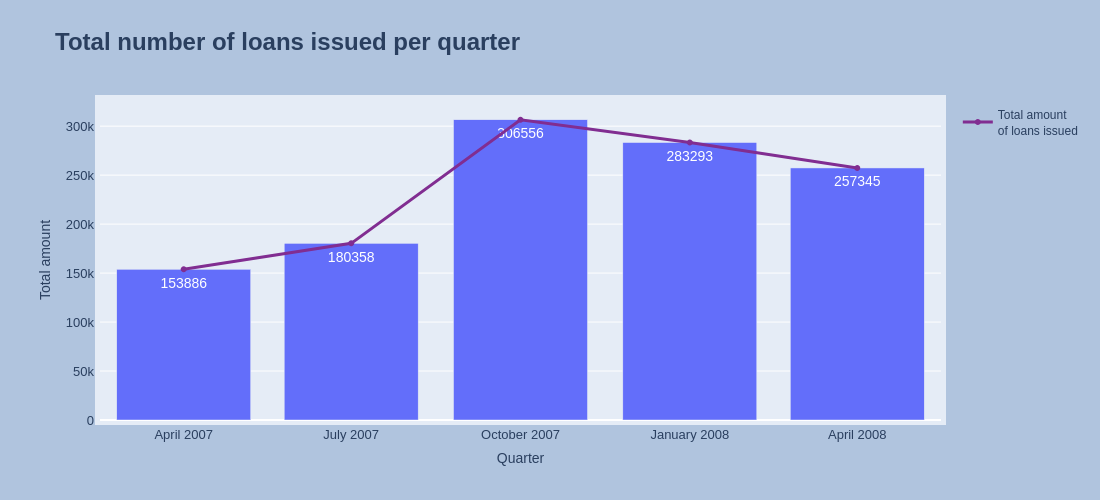

In [499]:
fig = px.bar(
    total_quarters,
    x = 'Quarter start date',
    y = 'Total amount',
    title = 'Total number of loans issued per quarter',
    labels = {'Quarter start date': 'Quarter'},
    text = 'Total amount',
    width = 800,
    height = 500
)

fig.update_traces(textfont_size=14, textangle=0, textposition="inside", cliponaxis=False)
fig.update_layout(xaxis = dict(
    tickmode = 'array',
    tickvals = total_quarters['Quarter start date'],
    tickfont_size = 13,
    tickformat = '%B %Y'
), 
    yaxis = dict(
        tickfont_size = 13
    ),
    title_font = dict(size = 24, weight = 'bold'),
    margin=dict(l=100, pad = 5),
    paper_bgcolor="LightSteelBlue"
)
fig.add_trace(go.Scatter(
    x = total_quarters['Quarter start date'], 
    y = total_quarters['Total amount'], 
    name = 'Total amount <br>of loans issued',
    marker_color = '#812d91',
    line_width = 3
))
fig.update_yaxes(automargin='left+top')
fig.show()

<div class = 'alert alert-box alert-success'>
    
>Based on the data and graph, we cannot make assumptions about the growth or decline of loans issued. Unfortunately, we don't have enough data to draw any conclusions in the long term.
    
</div>

## Total number of loan applications per month

In [418]:
total_per_month = pd.read_csv('german_credit.csv', parse_dates=['contract_dt']).sort_values('contract_dt').reset_index(drop = True)
total_per_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   age               1000 non-null   int64         
 1   sex               1000 non-null   object        
 2   job               1000 non-null   int64         
 3   housing           1000 non-null   object        
 4   saving_accounts   817 non-null    object        
 5   checking_account  606 non-null    object        
 6   credit_amount     1000 non-null   int64         
 7   duration          1000 non-null   int64         
 8   purpose           1000 non-null   object        
 9   default           1000 non-null   int64         
 10  contract_dt       1000 non-null   datetime64[ns]
 11  client_id         1000 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(5)
memory usage: 93.9+ KB


In [500]:
# get all months from period
months = pd.period_range(start = total_per_month['contract_dt'].dt.to_period('M').min(), 
                end = total_per_month['contract_dt'].dt.to_period('M').max()).to_frame(name = 'month').reset_index(drop = True)
months

,month
0,2007-05
1,2007-06
2,2007-07
3,2007-08
4,2007-09
5,2007-10
6,2007-11
7,2007-12
8,2008-01
9,2008-02


In [446]:
sum_per_month = (
    total_per_month
    .assign(month = lambda x: x['contract_dt'].dt.to_period('M'))
    .groupby('month')
    [['credit_amount']].sum()
)
sum_per_month

,credit_amount
month,
2007-05,207663
2007-06,239594
2007-07,224333
2007-08,178569
2007-09,186909
2007-10,188534
2007-11,300504
2007-12,273973
2008-01,288080


In [463]:
sum_per_month = months.merge(sum_per_month, on='month', how='left')

In [468]:
sum_per_month.reset_index(drop = True, inplace=True)

In [472]:
sum_per_month = (
    sum_per_month
    .assign(month = lambda x: x['month'].astype('string'))
)

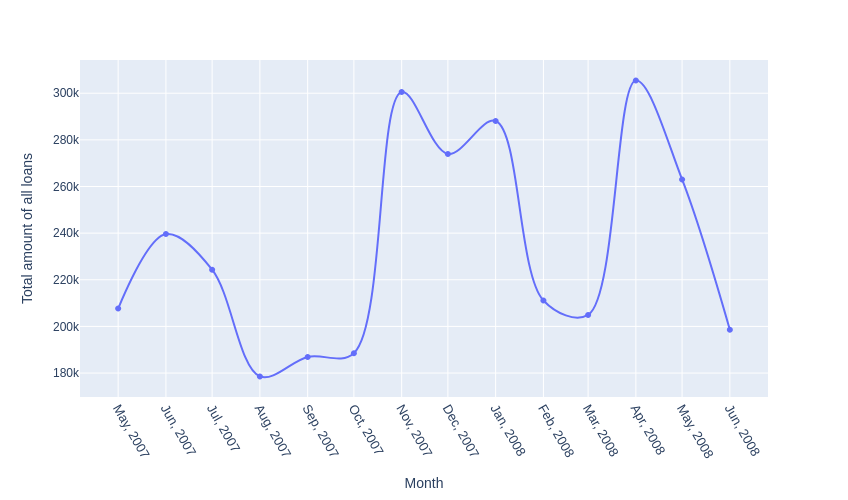

In [508]:
fig = px.line(sum_per_month, 
            x = 'month', 
            y = 'credit_amount', 
            markers = True,
            line_shape = 'spline',
            labels = {'month': 'Month', 'credit_amount': 'Total amount of all loans'},
            width = 1000,
            height = 500
             )
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = sum_per_month['month'],
        tickfont_size = 13,
        tickformat = '%b, %Y'
    )
)
fig.update_xaxes(tickangle = 60)
fig.show()

<div class = 'alert alert-box alert-success'>

> Based on available data, it can be assumed that people are more active in taking out loans in the pre-New Year period and in the period before the start of the summer holiday season. But we do not have enough data to confirm these hypotheses.
</div>

### Sum of all loan requests by gender